## The full Image Analysis Workflow

In this notebook, we will build a complete, end-to-end image analysis pipeline. 

We'll start with a complex, multi-channel image, learn how to load, inspect and process it, extract quantitative data, and finally, automate the entire workflow to run on a batch of images.

Workflow:
1. Image handling: Loading multi-dimensional data, inspecting it, and slicing out regions of interest.
2. Processing workflow:
    - Pre-processing: Cleaning up image noise with filters.
    - Segmentation & post-processing: Finding objects with thresholding and cleaning them with morphological operations.
4. Measurement & Analysis: Turning segmented objects into a table of data for plotting and statistical testing.
5. Automation: Automating processing and scaling the analysis from one image to many.

---
---
### Lesson 1: Load image data and metadata

When working with microscopy or scientific images, the first step is to **load the image** and explore its **metadata**. 

Understanding the file type and metadata is crucial for processing, analyzing, and storing images correctly.

**Common Bioimage file types**

In microscopy and scientific imaging, images can come in a wide range of **file formats**, each with different capabilities. 


| File Type      | Typical Use Case / Notes                                                      | Bit Depth |
|-------------|------------------------------------------------------------|--------------|
| **TIFF / TIF** | Standard in microscopy; supports multi-dimensional images (z-stacks, time-lapse, channels..)   | 8–32      |
| **OME-TIFF (.ome.tif)** | Open Microscopy Environment (OME) format, stores multi-dimensional images with metadata | 8–32      |
| **JPEG / JPG** | Compressed (lossy) images, not suitable for analysis               | 8         |
| **PNG**        | Lossless 8-bit/16-bit 2D images, supports transparency                          | 8–16      |
| **Zarr (.zarr)**| Chunked, compressed storage for very large multi-dimensional datasets         | 8–32      |
| **OME-Zarr (.ome.zarr)**| Zarr with OME metadata         | 8–32      |
| **Proprietary formats** (e.g., `.czi` Zeiss, `.lif` Leica, `.nd2` Nikon) | Often contain full acquisition metadata but might require specialized readers | varies    |

**Example generic reading libraries**
- `skimage.io` (from *scikit-image*), `imageio`,  `tifffile`, `PIL.Image` (from *Pillow*), `AICSImageIO.AICSImage` x `BioIO` (*AICSImageIO* has been merged into the new *bioio* ecosystem and is no longer actively developed)

**Example specialized format reading libraries**
-  `czifile`, `readlif`, `nd2`, `nd2reader`

**Key Points**

- **Images are arrays**: Whatever the format, libraries usually convert data to a **NumPy array** (or Dask array for Zarr).  
- **Metadata** are additional information: Pixel size, physical units, channel names, acquisition settings... — *not all libraries can read metadata*, *not all file-formats have stored matadata*.  
- **Large datasets**: Zarr or HDF5 formats are useful when images don’t fit in memory.  
- **Proprietary formats**: Often require **specialized libraries**; trying to open with a generic library may fail or lose metadata.


In [ ]:
# Remember, first we need to import packages
import imageio.v3 as iio
import numpy as np


# Define a path to image
image_location = r'../data/mitosis.tif'

# Read image metadata (if available)
metadata = iio.immeta(image_location)
print(metadata)

# for key,value in metadata.items():
#     print(f'{key}: \t {value}') # \t is for tab; \n for newline

In [ ]:
# Note about file paths

# Absolute path: full address on the filesystem
absolute_path = "C:/Users/Username/Documents/demo_cells_image.tif"
print("Absolute path:", absolute_path)

# Relative path: relative to where your Python script / notebook is running
# Special relative markers:
#   .  = current directory
#   .. = parent directory (one level up)
relative_path = "../data/demo_cells_image.tif"
print("Relative path:", relative_path)

# Raw string (r"..."): avoids interpreting backslashes as escape sequences
raw_path = r"C:\Users\Username\Documents\demo_cells_image.tif"
print("Raw string path:", raw_path)

# We will discuss more about dedicated libraries during batch processing

In [ ]:
# Read image data
image_stack = iio.imread(image_location)

# Inspect image dimensions
print("The full data is a NumPy array with the following properties:")
print(f"Object type: {type(image_stack)}")
print(f"Data type: {image_stack.dtype}")
print(f"Dimensions: {image_stack.ndim}")
print(f"Shape: {image_stack.shape}") # TZCYX

In [ ]:
# Plot single slice
import matplotlib.pyplot as plt

single_slice_ch1 = image_stack[0,2,0,:,:] # 1st timepoint, 3rd slice, 1st channel
single_slice_ch2 = image_stack[0,2,1,:,:] # 1st timepoint, 3rd slice, 2nd channel


fig, ax = plt.subplots(1,2)

ax[0].imshow(single_slice_ch1, cmap='gray')
ax[0].set_title("Channel 0")
ax[0].axis('off')

ax[1].imshow(single_slice_ch2, cmap='gray')
ax[1].set_title("Channel 1")
ax[1].axis('off')
plt.show()

In [ ]:
# Browse a stack
import stackview # Interactive image stack viewing in jupyter notebooks
print(stackview.__version__)

stackview.slice(image_stack) # we need version > 0.10 to use this


In [ ]:
# Stackview has additional methods for customized view

channels = [image_stack[:,:,0,:,:], image_stack[:,:,1,:,:]]
colormaps = ["pure_green", "pure_magenta"] 

stackview.switch(images=channels, colormap=colormaps, toggleable=True)

#### Inspect intensity data

It is often useful to explore the distribution of pixel intensities before performing any further analysis. 

This can helps us identify:
- Background vs. foreground signal
- Differences between channels
- Outliers or artifacts

In [ ]:
# stackview.insight() function provides a quick overview of the intensity distribution
# but it does so for the whole array
stackview.insight(image_stack)

If we want more control over plotting or calculating statistics, we can flatten the multi-dimensional arrays of each channel using function `flatten()`, or `ravel()` 

In [ ]:
# plot histogram per channel

ch0_data = image_stack[:, :, 0, :, :].ravel()   # Flatten everything 
ch1_data = image_stack[:, :, 1, :, :].flatten()

plt.figure(figsize=(8, 5))
plt.hist(ch0_data, bins=100, alpha=0.5, label="Channel 0 - DNA")
plt.hist(ch1_data, bins=100, alpha=0.5, label="Channel 1 - fibers")
#plt.xlim(1000, 10000)
plt.legend()
plt.show()

In [ ]:
# Compute and print basic descriptive statistics for each channel:
print("Channel 0: min =", np.min(ch0_data), 
      ", max =", np.max(ch0_data),
      ", mean =", np.mean(ch0_data), 
      ", std =", np.std(ch0_data))

print("Channel 1: min =", ch1_data.min(), 
      ", max =", ch1_data.max(),
      ", mean =", ch1_data.mean(), 
      ", std =", ch1_data.std())

#### Image transformations

In [ ]:
# Lets read a new image

image = iio.imread('../data/nuclei_stack1.tif')

print(image.shape)

stackview.slice(image)

In [ ]:
# Image cropping
# Can be done simply by slicing array

crop_area1 = image[:,520:,420:]
print(crop_area1.shape)

stackview.slice(crop_area1, zoom_factor=3)

#### Projections

Collapses a stack along an axis to reduce dimensions.

Common projections include:
- **Maximum intensity projection (MIP)**: For each pixel, take the highest intensity across slices. 
- **Minimum intensity projection**: Opposite of min
- **Average (mean) projection**: Computes the mean intensity at each pixel. 
- **Sum projection**: Sums intensities across slices.

In [ ]:
# Projections
# We can collapse one axis (e.g., z-axis in a 3D stack) using functions (sum, mean, max, min, ...)

# Examples - for convenience we will put it to a dictionary
projections = {
    "Max": np.max(image, axis=0),
    "Min": np.min(image, axis=0),
    "Mean": np.mean(image, axis=0),
    "Sum": np.sum(image, axis=0),
}


print(image.shape)
print(projections['Max'].shape)

In [ ]:
# Plot images
fig, axes = plt.subplots(1, len(projections), figsize=(20, 5))
for index, ax in enumerate(axes):
    ax.imshow(list(projections.values())[index], cmap='gray') # set vmax to unify colorscale
    ax.set_title(f"{list(projections.keys())[index]} Projection")
    ax.axis('off')
plt.show()

##### --- ***Exercise*** ---

1. Use imageio.v3 library to read image file from a provided path. 

2. Inspect image dimensions.

3. Visualize image with stackview.

4. In a new cell, compute and plot a maximum projection along time axis.

5. In a new cell, plot intensity histogram of projection.

In [ ]:
image_path = '../data/mouse_SC_single.tif'

# Your code here


<details>
<summary>Click to see the example solution</summary>

```python
import imageio.v3 as iio

# 1. Load image
exercise_img = iio.imread(image_path)

# 2. Inspect properties
print(exercise_img.shape, exercise_img.dtype)

# 3. View image with stackview
stackview.slice(exercise_img)

# 4. Compute and plot max projection
mp = np.max(exercise_img, axis=0)

plt.imshow(mp, cmap='gray')

# 5. Plot intensity histogram of projection
flat = mp.flatten()

plt.hist(flat, bins = 100)
plt.show()

````

#### Geometric transformations

In [ ]:
# Transformation module
from skimage import transform

dir(transform)

In [ ]:
# Rotation

# Select a 2D projection for demonstration
max_proj = projections['Max']

# Some rotations are possible directly in numpy - no interpolations needed
rotated_90 = np.rot90(max_proj, k=1) # you can use numpy for 90 degrees multiples

# Specialized library is needed for arbitrary angles - Uses interpolation to compute pixel values at rotated positions
rotated_45 = transform.rotate(max_proj, angle=45, resize=True) # or skimage transform functions (allows interpolation)


# Plot images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(max_proj, cmap='gray')
axes[0].set_title('Original')

axes[1].imshow(rotated_90, cmap='gray')
axes[1].set_title('Rotated 90°')

axes[2].imshow(rotated_45, cmap='gray')
axes[2].set_title('Rotated 45°')

for ax in axes:
    ax.axis('off')
    
plt.show()

In [ ]:
# Rescale (resize)
from skimage.measure import block_reduce

down_scaled = transform.rescale(max_proj, scale=0.25, preserve_range=True)
binned = block_reduce(max_proj, block_size=(4,4), func=np.sum)

In [ ]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

im0 = axes[0].imshow(max_proj, cmap='gray')
axes[0].set_title('Original')
fig.colorbar(im0, ax=axes[0], fraction=0.045)

im1 = axes[1].imshow(down_scaled, cmap='gray')
axes[1].set_title('Down-scaled')
fig.colorbar(im1, ax=axes[1], fraction=0.045)

im2 = axes[2].imshow(binned, cmap='gray')
axes[2].set_title('Binned-sum')
fig.colorbar(im2, ax=axes[2], fraction=0.045)

plt.show()

---
---

### Lesson 2: Processing workflow

#### Pre-processing

**Image Filtering**

A filter is a mathematical operation applied to an image to modify or extract information from it. 

Filters can be used to:

- Reduce noise (smoothing) - (e.g. Gaussian, Median)
- Highlight edges or boundaries - (e.g. Sobel)
- Enhance contrast
- Extract patterns or textures

Most filters are implemented using a **kernel** (not Jupyter Notebook kernel).
- A kernel is a small array of coeficients that defines how neighboring pixels are combined.
- The kernel is slid across the image, and for each position, a new pixel value is computed based on the neighborhood defined by the kernel.
- This operation may be:
    - Convolution: a weighted sum of neighbors (kernel coefficients act as weights)
    - Rank filter: e.g., median, maximum, minimum
    - Other neighborhood operations: e.g., morphological filters like dilation/erosion
- The result is a new image where each pixel represents the effect of the kernel on its neighborhood.
- Kernel size affects the scale of the effect: small kernels for fine details, large kernels for broader effects.

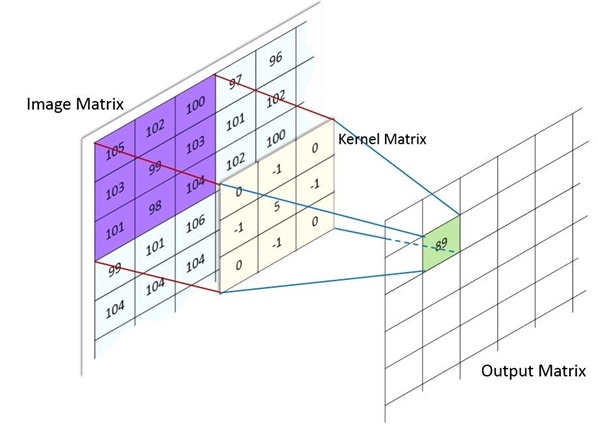

[source](https://www.linkedin.com/pulse/image-processing-convolution-filters-calculation-gradients-yadav)

In [ ]:
# We will define a convenient helper function for plotting side by side pair of images

def plot_comparison(original, modified, modified_title=None, cmap='gray'):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
    ax1.imshow(original, cmap=cmap); ax1.set_title('Original')
    ax2.imshow(modified, cmap=cmap); ax2.set_title(modified_title)
    plt.show()

In [ ]:
# Apply filters
from skimage import filters

image_frame = image[0, :, :]

# Apply a Gaussian filter to nuclei. 
# 'sigma' controls the amount of smoothing
blurred_image = filters.gaussian(image_frame, sigma=1.0)

plot_comparison(image_frame, blurred_image, "After Gaussian Blur")


In [ ]:
# Apply rank filters

# Apply a Median filter to nuclei. 
median_filtered_image = filters.rank.median(image_frame)

plot_comparison(image_frame, median_filtered_image, "Median filter")

##### --- ***Exercise*** ---

Create 2 blurred images of the original - image_frame.
- one with small sigma (~ 2)
- other with large sigma (~ 10)

Use plot_comparison function to plot both blurred versions side by side.

In [ ]:
# Your code here


#### Segmentation

Segmentation separates the image into meaningful regions (e.g., cells, nuclei, mitochondria). 

Example segmentation approaches:
- **Intensity thresholding**: Converts grayscale images to binary masks. 
    - Pixels above/below a threshold are divided into 2 classes - e.g. “foreground/background”. 
    - Thresholds can be manually chosen or computed automatically (e.g., Otsu’s method).
- **Edge detection**: Finds boundaries of objects based on intensity gradients.
- **Watershed**: Separates touching objects using topographic representation of intensity as landscapes.

In [ ]:
# Segmentation 

# Use Otsu's method to find the optimal threshold value.
otsu_threshold = filters.threshold_otsu(image_frame)
print(f"The automatically determined Otsu threshold is: {otsu_threshold}")

# Apply the threshold to create the binary mask.
mask = image_frame > otsu_threshold

plot_comparison(image_frame, mask, "Otsu's Threshold Applied")

In [ ]:
# Use filtered image as input 

otsu_threshold = filters.threshold_otsu(blurred_image)
mask = blurred_image > otsu_threshold

plot_comparison(blurred_image, mask, "Otsu's Threshold Applied")

#### Post-processing

After segmentation, binary masks might require refinements to improve object shapes and remove artifacts. 

This can include filling holes, connecting broken pieces, or removing small particles.

Morphological operations on binary masks:
- *Erosion*: Shrinks objects
- *Dilation*: Expands objects
- *Opening*: erosion → dilation
- *Closing*: dilation → erosion

In [ ]:
# Post processing of binary mask
from scipy import ndimage as ndi
from skimage import morphology

mask_filled = ndi.binary_fill_holes(mask) # Fill holes 
mask_opened = morphology.opening(mask_filled, morphology.disk(3)) #opening 
mask_cleaned = morphology.remove_small_objects(mask_opened, min_size=100) # Remove small objects (noise)

In [ ]:
plot_comparison(mask, mask_cleaned, 'cleaned mask')

##### Connected components labeling ~ instance segmentation

In [ ]:
# Connected components labeling 
from skimage import measure

labels = measure.label(mask_cleaned)

print(f"Found {labels.max()} objects after cleaning and labeling.")

plot_comparison(mask_cleaned, labels, 'Labels', cmap='nipy_spectral')

##### Watershed 

Watershed algorithm is a method often used for separating connected (touching) objects in a binary mask. 

It treats the image as a topographic surface, where bright regions are “peaks” and dark regions are “valleys.” The algorithm “floods” the valleys starting from predefined markers until regions meet, creating boundaries between objects.

On binary masks:
- We first compute the distance transform, where object centers have higher values.
- These centers are considered peaks, which are then used as markers.
- The watershed is applied on the negative distance map so that the peaks become valleys for flooding.

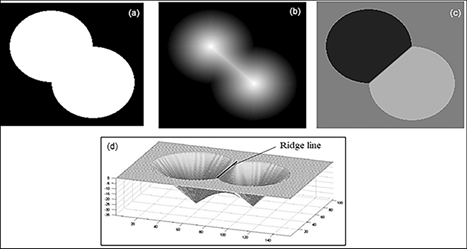

[source](https://www.researchgate.net/figure/Schematic-diagram-of-image-segmentation-with-the-watershed-algorithm-Source-Rabbani-et_fig4_377269538)

In [ ]:
# Apply watershed in python
from skimage import segmentation
from scipy import ndimage as ndi
from skimage.feature import peak_local_max

# Do distance transformation of our binary mask
distance = ndi.distance_transform_edt(mask_cleaned)

# Extract markers (peaks)
coords = peak_local_max(distance, min_distance=20, labels=mask_cleaned) # this is a list of coordinates

# We need to create an empty image and substitute pixels at marker positions with unique values
markers = np.zeros_like(distance, dtype=int)
for i in range(len(coords)):
    markers[coords[i, 0], coords[i, 1]] = i + 1

# Watershed method on negative distance transform with provided markers
labels_watershed = segmentation.watershed(-distance, markers, mask=mask_cleaned)

# Plot results
plot_comparison(labels, labels_watershed, 'Watershed', cmap = 'nipy_spectral')

In [ ]:
# Lets visualize the steps as a stack

# Dilate markers to make them easier to see
dilatated_binary_markers = morphology.dilation(markers)>0

# Define list of wanted images
steps = [mask_cleaned, distance, dilatated_binary_markers, labels_watershed]

# Concatenate images into a stack
processing_stack = np.stack(steps, axis = 0)

# View
stackview.slice(processing_stack)

In [ ]:
# Plot as overlay
# multiple options (napari, matplotlib with alpha, sepcialized packages - label2rgb or stackview)
stackview.blend(image_frame, labels_watershed)

### Summary of our Workflow
We've just completed a basic image processing pipeline:
1. **Loaded** an image.
2. **Pre-processed** it by applying a Gaussian blur to reduce noise.
3. **Segmented** the nuclei class from the background by applying an automatic Otsu threshold.
4. **Refined** the resulting mask by using post-processing steps such as morphological operations.
5. Distinguised individual objects in binary mask with **connected components labeling**


##### --- ***Exercise*** ---

Perform the following steps to build a workflow to process an image.

1. Load the image from the assigned `image_path` variable.
2. Inspect it's properties.
    - find out the dimensions, size and data type of pixel values
    - (optional) inspect metadata if it exists
3. Show image in notebook (stackview or matplotlib)
4. Extract the mitochondrial channel (2nd)
5. The image is a bit noisy with high background. 
    - Apply an apropriate filter.
    - optionally, remove background using skimage.restoration.rolling_ball - 
        *Hint:* you need to first import it.
        The output of this function is a background image, not background subtracted image.
6. Plot histogram of blurred/corrected image.
7. Compute automatic thresholds using Otsu and Mean methods.
8. Segment the image using both threshold methods and choose the best one.
    - Use `plot_comparison()` to show the two binary masks side by side.
9. (optional) Improve segmentation 
    - Apply morphological operations to clean the mask (skimage.morphology)
10. Perform instance segmentation to get labels of individual objects
11. Visualize the results
    - Show the labeled objects over the original mitochondrial channel (e.g., using stackview.blend)

In [ ]:
image_path = '../data/BPAE.tif'

# Your code here


<details>
<summary>Click to see the example solution</summary>

```python
from skimage import restoration

# 1. Load image
img = iio.imread(image_path)

# 2. Inspect properties
print(img.shape, img.size, img.dtype)

img_metadata = iio.immeta(image_path)
print(img_metadata)

# 3. Visualize
stackview.slice(img)
plt.show()

# 4. Extract mitochondrial channel
mito = img[1,:,:]

# 5. Denoise / background removal
i = filters.gaussian(mito, sigma=2)
i = i - restoration.rolling_ball(i, radius=15)
i = i.astype(np.uint16)

plt.imshow(i, cmap='gray')
plt.show()

# 6. Histogram
plt.hist(i.ravel(), bins=50)
plt.yscale('log')
plt.show()

# 7. Automatic thresholds
otsu_thr = filters.threshold_otsu(i)
mean_thr = filters.threshold_mean(i)
print(otsu_thr, mean_thr)

# 8. Segment
mask_otsu = i > otsu_thr
mask_mean = i > mean_thr

plot_comparison(mask_otsu, mask_mean)

# 9. Morphological cleaning (optional)

# 10. Instance segmentation
labels = morphology.label(mask_otsu)

# 11. Visualization
stackview.blend(mito, labels)
````

<br><br>

#### Operations between masks

In image analysis, it is often useful to combine or compare different binary masks to extract specific regions of interest. 

Masks as boolean arrays (True for foreground, False for background), can be processed with logical operations to create new masks.

Common operations:
- *Inversion - NOT (`~`)* – flips all boolean values:
    ```python
    inverted_mask = ~mask
    ```
- *Intersection (`&`)* – keeps only pixels present in both masks:
    ```python
    overlap_mask = mask1 & mask2
    ```
- *Union (`|`)* – includes all pixels present in either mask:
    ```python
    combined_mask = mask1 | mask2
    ```
- *Difference / Subtraction (`& ~`)* – removes pixels of one mask from another:
    ```python
    cytoplasm_mask = cell_mask & ~nuclei_mask
    ```
- *Exclusive OR (`^`)* – pixels present in one mask or the other, but not both:
    ```python
    xor_mask = mask1 ^ mask2
    ```

In [ ]:
# Tilde operator
mask = np.array([True, False, True])
inverted_mask = ~mask
inverted_mask

In [ ]:
# Use-case

cell_mask = iio.imread('../data/BPAE_actin_mask.tif')
background_mask = ~cell_mask

plot_comparison(cell_mask, background_mask, 'background')

**Example Use Case:**

You have a cell_mask, a nuclei_mask, and a mitochondria_mask. 

If you want to extract the cytosol region, you can subtract the nucleus and mitochondria regions from the whole cell mask.

In [ ]:
# Read segmentation of mitochondria
mito_labels = iio.imread('../data/BPAE_mito_lbl.tif')
mito_mask = (mito_labels > 1) # convert to boolean array

# Read nuclei masks
nuclei_mask = iio.imread('../data/BPAE_nuclei_mask.tif')

# Logical operations to extract cytoplasm region
cytoplasm_mask = cell_mask & ~nuclei_mask & ~mito_mask

In [ ]:
# Plot masks

# List of images and titles
images = [cell_mask, mito_mask, nuclei_mask, cytoplasm_mask]
titles = ['Cell mask', 'Mitochondria', 'Nuclei', 'Cytoplasm']

# Create subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for ax, img, title in zip(axes, images, titles):
    ax.imshow(img, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()

---
---

### Lesson 3: Measurements

The `measure.regionprops_table()` function from scikit-image computes quantitative features for each labeled region in an image.  

Each connected region (identified by a unique label) can be characterized by geometric and intensity-based properties.

The output of this function is a is a dictionary containing one array per measured property.

In [ ]:
# Measurements
 
# We specify which properties we want to measure for each object.
properties_to_measure = ('label', 'area', 'mean_intensity', 'perimeter', 'eccentricity')

# regionprops_table uses our `labels` image and the original `nuclei_image`
props_dict = measure.regionprops_table(
    labels_watershed,
    intensity_image=image_frame,
    properties=properties_to_measure
)

props_dict

In [ ]:
# Convert the dictionary of results into a Pandas DataFrame
import pandas as pd

image_df = pd.DataFrame(props_dict)

image_df.head(5) # show first 5 rows of a table

---
---

### Lesson 4: Automation

In the previous Lesson, we practiced designing and tuning a full image-processing workflow:
- We loaded and visualized microscopy images.
- We adjusted individual processing steps such as filtering, thresholding, and segmentation.
- We extracted quantitative measurements (e.g., area, intensity, circularity).

That workflow worked — but it was **manual**.  
Each change in parameters required editing the code and re-running it, which is inefficient when you want to test multiple settings or process multiple images.

Now we’ll make our work **smarter and faster** by introducing two types of automation:

1. **Parameter Sweep:**  
   Applying *different settings* (e.g., filter size, threshold method) to the **same image**, so we can compare their effects.

2. **Batch Processing:**  
   Applying *final workflow* to **many images**, so we can process entire datasets automatically.


---
##### Parameter Sweep Example

Let’s compare how different levels of Gaussian blur affect the same image.

- We define a list of parameter values (sigma_values) to test.
- We use a simple **loop** to apply the same function with each parameter.
- We use another **loop** to plot images with subplots

In [ ]:
# Load one image
input_image = iio.imread('../data/noisy_cells.tif')

# Define list of sigma values for Gaussian blur
start = 1
stop = 12
step = 2
sigma_values = list(range(start, stop, step))

# Apply Gaussian filter with different sigmas
blurred_images = []
for sigma in sigma_values:
    blurred = filters.gaussian(input_image, sigma=sigma)
    blurred_images.append(blurred)

# Alternative: list comprehension
# blurred_images = [filters.gaussian(image, sigma=s) for s in sigma_values]

In [ ]:
# Plot results side by side
scale = len(sigma_values)
fig, axes = plt.subplots(1, scale, figsize=(5*scale, 5))

# zip() is a built-in Python function 
# it lets you iterate over multiple sequences (lists, tuples...) in parallel
for ax, s, img in zip(axes, sigma_values, blurred_images):
    ax.imshow(img, cmap="gray")
    ax.set_title(f"σ = {s}")
    ax.axis("off")

plt.suptitle("Effect of Gaussian Blur with Different σ", fontsize=16)
plt.show()

##### --- ***Mini Exercise*** ---

Practice zip function.

In [ ]:
numbers = [1,2,3,4]
dictionary = {
    'dogs': 2,
    'cats': 9,
    'sloths': 11,
    'spiders': 999

}

# Work with me to use zip


##### --- ***Exercise*** ---

Test how different thresholding algorithms segment the same image.

- Use image from the demo code (input_image).
- Create a dictionary of thresholding methods (Otsu, Li, Yen, Minimum).
    - such as `methods = {'name1': function1(), 'name2': function2()}`
- Create a new empty dictionary to store results.
- Use a loop to iterate over the methods in dictionary (*Hint: loop through the dictionary items using `for key, value in methods.items()`)
    - apply thresholding method to get threshold value
    - generate a binary mask applying given threshold value
    - store binary array in the new dictionary under the method name (*Hint: store value under key with `new_dictionary[key]=value`*)
- Optional: Plot binary arrays in one figure. (*Hint: you can iterate over axis and dict items together with `for ax, (key, value) in zip(axes, dict.items()`*)
    - Optional: Plot the original image alongside binary arrays in one figure.

In [ ]:
# Your code here


<details>
<summary>Click to see the example solution</summary>

```python
from skimage.filters import threshold_otsu, threshold_li, threshold_yen, threshold_minimum

# Dictionary of thresholding methods
methods = {
    "Otsu": threshold_otsu,
    "Li": threshold_li,
    "Yen": threshold_yen,
    "Min": threshold_minimum
}

# Create empty dictionary to store masks
masks = {}

# Apply each thresholding method in a loop
for name, func in methods.items():
    thresh = func(input_image)        
    mask = input_image > thresh      
    masks[name] = mask          

# Optional: Add original image to the new dictionary to plot it along
masks['raw'] = input_image

# Optional: Plot original image + threshold results
fig, axes = plt.subplots(1, len(masks), figsize=(16, 5))

for ax, (name, mask) in zip(axes, masks.items()):
    ax.imshow(mask, cmap="gray")
    ax.set_title(name)
    ax.axis("off")

plt.show()
```

<br><br>

In [ ]:
# By the way, skimage has a function to try several thresholds

filters.try_all_threshold(input_image, figsize=(8, 5), verbose=False)
plt.tight_layout()


---

##### Automated workflow


Now, we will apply a complete workflow automatically. Image → segmentation → measurements → results table.

We will simply take the individual steps and package them into a function.


Fast functions recap:

```python
# function definition - use def keyword
def function_name(argument1, argument2, ...): # function can have any number of arguments
    
    # docstring (optional)
    """Function description""" 

    # Function body: indented block of code
    step1 .. 
    step2 ..
    result = .. 

    # return statement (optional)
    return result # function can return more then one value
```

In [ ]:
# Build full workflow - from image to table

def analyze_slice(image_array, slice_index = 0):
    '''
    Perform basic segmentation on a 2D image.
    Return object measurements and label image.
    '''
    filtered_array = filters.gaussian(image_array, sigma=3) # Apply Gaussian smoothing
    threshold_value = filters.threshold_otsu(filtered_array) # Apply Otsu threshold
    mask = filtered_array > threshold_value # Create binary mask
    processed_mask = ndi.binary_fill_holes(mask) # Fill holes
    mask_cleaned = morphology.remove_small_objects(processed_mask, min_size=100) # Remove small objects
    label_image = measure.label(mask_cleaned) # Segment instances of objects
    props_dict = measure.regionprops_table(label_image, intensity_image=image_array, # Measure parameters
                                           properties=('label', 'area', 'mean_intensity'))
    props_dict['slice'] = slice_index # Add the slice index to properties dictionary
    results_df = pd.DataFrame(props_dict) # Convert properties dictionary to a DataFrame
    return results_df, label_image # Return DataFrame and label image


In [ ]:
# We will run our function on single slice and validate results

image_3d = iio.imread('../data/nuclei_stack1.tif')

print(image_3d.shape)

In [ ]:
input_slice = image_3d[10,:,:]

my_results, my_label = analyze_slice(input_slice, 10)

my_results

In [ ]:
plot_comparison(input_slice, my_label)

In [ ]:
# Now we can use our function in a loop to easily process all slices

# get number of slices in our image
n_slices = image_3d.shape[0]

# initialize empty variables for storing outputs
new_df = pd.DataFrame() # empty DataFrame
labels = [] # empty list

# run loop
for index in range(n_slices):
    # Print progress
    print('Processing slice:', index)

    # Analyze one slice
    result_df, result_labels = analyze_slice(image_3d[index,:,:], index)
    
    # Append results to a DataFrame
    new_df = pd.concat([new_df, result_df], ignore_index=True)
    
    # Store labels in a list for later use
    labels.append(result_labels)

print('Finished!')

In [ ]:
# Show DataFrame
new_df

In [ ]:
# View stack of labels
labels_stack = np.stack(labels)
stackview.slice(labels_stack)

##### --- ***Exercise*** --- 

**Create an Analysis Function** - Follow the steps below to build a new function. 

**Instructions:**
1. Define a function called `analyze_nuclei`.
2. This function should take two arguments: `image_array_path` (the image to process) and `image_name` (a string with file name).
3. Inside the function, read image array from given path.
4. Inside the function, perform the entire pipeline defined below (blur, threshold, clean, label).
   *Note: Care about the difference between argument name and variable name in pipeline.*
5. After labeling, use `measure.regionprops_table` to calculate the `'label'`, `'area'`, and `'mean_intensity'` for each nucleus. Remember to use the original `image_array` for the `intensity_image`. Store the results in a dictionary.
6. Add a new key to this dictionary called `'name'` and set its value to the `image_name` argument.
7. Convert the resulting dictionary to a Pandas DataFrame.
8. The function should `return` this final DataFrame and labels.
9. Test your function by calling it with the provided image. 
10. Print the resulting DataFrame and show resulting segmentation to check that it works.

```python
# processing pipeline
filtered_image = filters.gaussian(image, 1)
threshold_value = filters.threshold_otsu(filtered_image)
mask = filtered_image > threshold_value
processed_mask = ndi.binary_fill_holes(mask)
mask_cleaned = morphology.remove_small_objects(processed_mask, min_size=50) 
label_image = measure.label(mask_cleaned)
```


In [ ]:
test_image = iio.imread('../data/batch_analysis/i0.tif')

# Your code here


<details>
<summary>Click to see the example solution</summary>

```python
# Create function
def analyze_nuclei(image_array, image_name):

    filtered_array = filters.gaussian(image_array, sigma=1)
    threshold_value = filters.threshold_otsu(filtered_array)
    mask = filtered_array > threshold_value
    processed_mask = ndi.binary_fill_holes(mask)
    mask_cleaned = morphology.remove_small_objects(processed_mask, min_size=50)
    label_image = measure.label(mask_cleaned)

    properties = measure.regionprops_table(label_image, intensity_image=image_array,
                                      properties=['label', 'area', 'mean_intensity'])
    properties['name'] = image_name
    df = pd.DataFrame(properties)

    return df, label_image


# Call the analysis function
results_df, labels = analyze_nuclei(test_image, 'i0.tif')

# Print results
print(results_df)
# Or show first few rows
print(results_df.head())

# Show segmentation
plt.figure(figsize=(6,6))
plt.imshow(labels, cmap='nipy_spectral')
plt.title("Labeled Nuclei")
plt.axis('off')
plt.show()

# Optional: blend with original image using stackview
stackview.blend(test_image, labels)
```

##### --- **Exercise** ---

Use your function `analyze_nuclei` from previous code to analyze all images from the folder.

- You are given a function `read_images_to_dict` that reads all images in folder and extracts their names. It returns both in a dictionary: `images_dict[image_name] = image_array`.
- Use this function to read all images from given path `folder_path` - store the result in a new variable.
- Loop over the dictionary and analyze each image using your `analyze_nuclei` function
    - *Hint: You can use for name, image in images_dict.items():*
    - While looping, print currently processed image name and store the label images in a list
    - After the loop, stack all label images into a 3D array
    - Visualize label stack with `stackview.slice`

In [ ]:
def read_images_to_dict(folder_path):
    import os
    import imageio.v3 as iio

    images_dict = {}
    for filename in os.listdir(folder_path):
        full_path = os.path.join(folder_path, filename)
        img = iio.imread(full_path)
        images_dict[filename] = img
    return images_dict

folder_path = r'../data/batch_analysis/nuclei_data'

# Your code here


<details>
<summary>Click to see the example solution</summary>


```python
# EXAMPLE SOLUTION

# Read all images into a dictionary
nuclei_images_dict = read_images_to_dict(folder_path)

# Initialize list to store label images
label_stack = []

# Loop over images
for name, img in nuclei_images_dict.items():
    print("Processing:", name)
    
    # Analyze image (returns a dataframe and label image)
    _, labels = analyze_nuclei(img, name) # We can skip returned .. with _
    
    # Store label image
    label_stack.append(labels)

# Convert list to 3D NumPy array
label_stack = np.stack(label_stack, axis=0)

# Visualize
stackview.slice(label_stack)


```